## Задача

- Найти датасет с каггла на классификацию тестов, согласовать со мной
- Решать задачу по тому же алгоритму, что и для Classic ML, использовать те же шаблоны
- Сделать детальный анализ текста на этапе EDA
- Добавить этапы препроцессинга для текстов: токенизация, удаление пунктуации и стоп-слов
- Извлечь важные фичи из текста. Использовать count-based методы в качестве бейслайна: CountVectorizer, TFIDFVectorizer, HashingVectorizer, предварительно сделав feature engineering. Поверх них использовать Classic ML модели для классификации
- Выполнить классификацию с использованием нейросетей, использовать Tensorflow keras. Попробовать RNN, LSTM
- Сделать то же самое с использованием Pytorch (для практики)
- Попробовать использовать готовые эмбеддинги для токенов и инициализировать ими embedding слой. Посмотреть, улучшился ли результат
- Попробовать использовать предобученные модели (transformers, BERT, …). Смотреть варианты на huggingface
- Попробовать генерировать эмбеддинги для теста целиком, используя предобученные модели (в качестве этапа препроцессинга), а поверх использовать Classic ML модели. Можно так же попробовать эмбеддинги от OpenAI или любых других LLM

In [357]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [358]:
! pip install numpy pandas scikit-learn catboost matplotlib seaborn phik nltk wordcloud imblearn tensorflow tiktoken

## Описание

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

Title: title of news article

Text: body text of news article

Subject: subject of news article

Date: publish date of news article

target: target(0, 1)

In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from plots import *
from nlp import *

In [360]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nemow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [361]:
df = pd.read_csv('dataset.csv', index_col=0)

In [362]:
df.head(100)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
95,Roy Moore Supporting Republican LOSES It Afte...,If the scandal around the stories of Alabama S...,News,"November 14, 2017",0
96,That Story Trump Just Told The Press About Ob...,"On Tuesday, Donald Trump told a story about Ai...",News,"November 14, 2017",0
97,This 4-Year Old Tweet From Donald Trump Shows...,After Hollywood producer Harvey Weinstein was ...,News,"November 13, 2017",0
98,OOPS: Trump Judicial Nominee Didn’t Tell Cong...,This is a major conflict of interest that shou...,News,"November 13, 2017",0


0 - false, 1 - true

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [364]:
df['subject'].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

нужно прикрутить кодирование

In [365]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Пропусков нет

In [366]:
df.duplicated().sum()

np.int64(209)

дубликатов не так уж и много

In [367]:
df = df.drop_duplicates()

df.duplicated().sum()

np.int64(0)

In [368]:
df['target'].value_counts()

target
0    23478
1    21211
Name: count, dtype: int64

In [369]:
import re

def preprocessing(text):
    text = text.lower() # удалим все знаки препинания, ссылки и тд, а так же сделаем все слова с маленькой буквы
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    return text

In [370]:
cols_to_clean = ["title", "text"]

for col in cols_to_clean:
    df[col] = df[col].apply(preprocessing)

In [371]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df)

# df = tokenizer.texts_to_sequences(df)

In [372]:
df

,title,text,subject,date,target
0,donald trump sends out embarrassing new year ...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",0
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",0
2,sheriff david clarke becomes an internet joke...,on friday it was revealed that former milwauke...,News,"December 30, 2017",0
3,trump is so obsessed he even has obama s name...,on christmas day donald trump announced that h...,News,"December 29, 2017",0
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,fully committed nato backs new u s approach o...,brussels reuters nato allies on tuesday welcom...,worldnews,"August 22, 2017",1
44894,lexisnexis withdrew two products from chinese ...,london reuters lexisnexis a provider of legal ...,worldnews,"August 22, 2017",1
44895,minsk cultural hub becomes haven from authorities,minsk reuters in the shadow of disused soviet ...,worldnews,"August 22, 2017",1
44896,vatican upbeat on possibility of pope francis ...,moscow reuters vatican secretary of state card...,worldnews,"August 22, 2017",1


датасет сбалансирован

## EDA

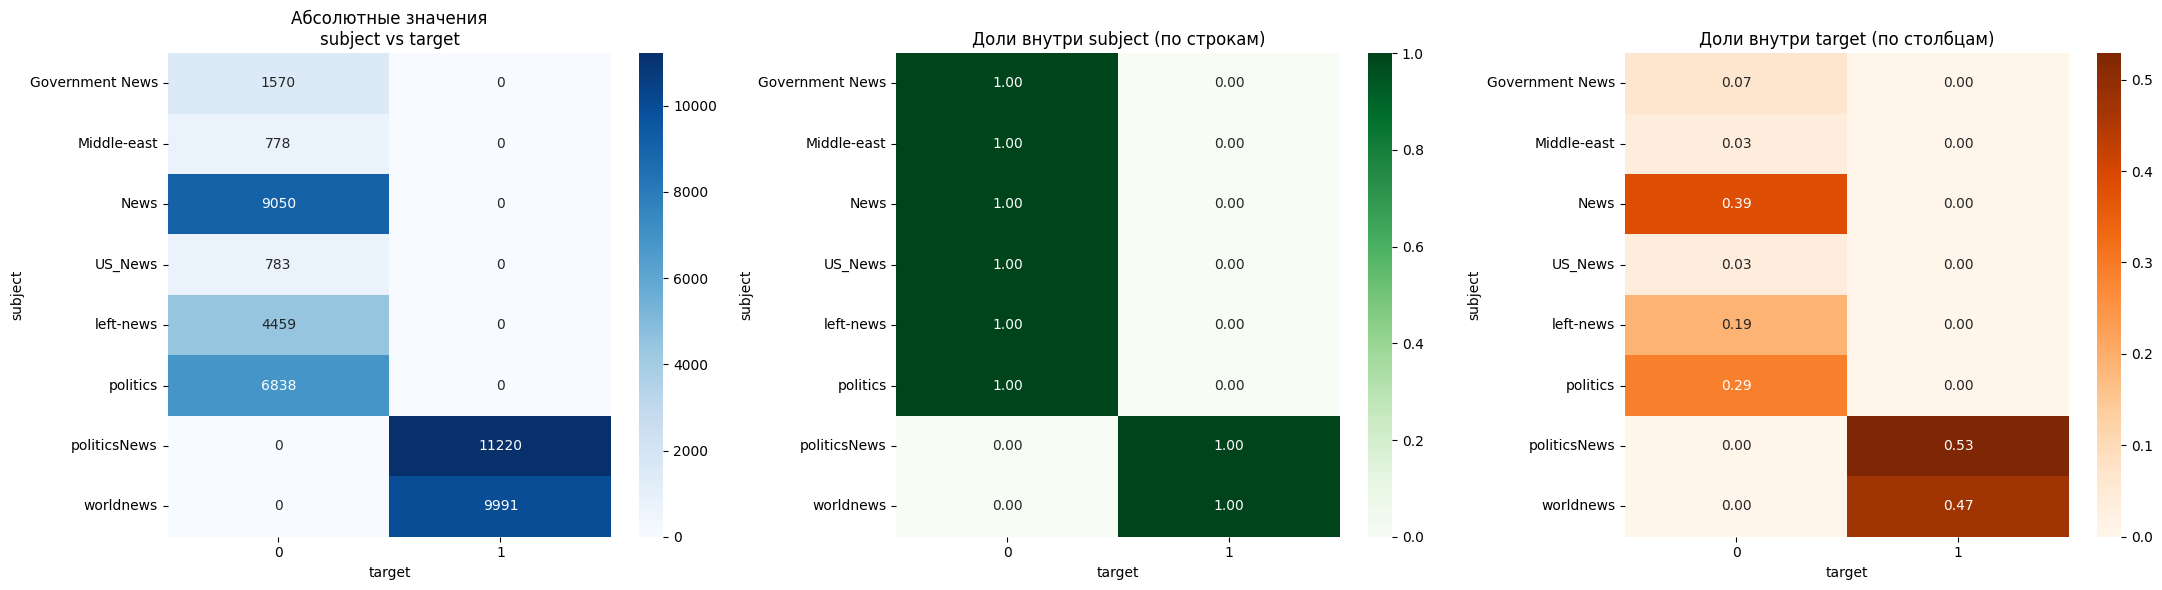

In [373]:
plot_categorical_relationship(df, 'subject', 'target')

крайне странное распределение, по какой то причине разные темы содержат только один таргет. при этом, это не ошибка склейки 2х датасетов. хотя, можно предположить что politics и politics_news, а так же news и world_news - одна категория по большому счету. в любом случае, исходя за такого распределения лучше всего избавиться от этой колонки позже

In [374]:
df['title_len'] = df['title'].fillna('').apply(lambda x: len(x.split()))

df['text_len'] = df['text'].fillna('').apply(lambda x: len(x.split()))

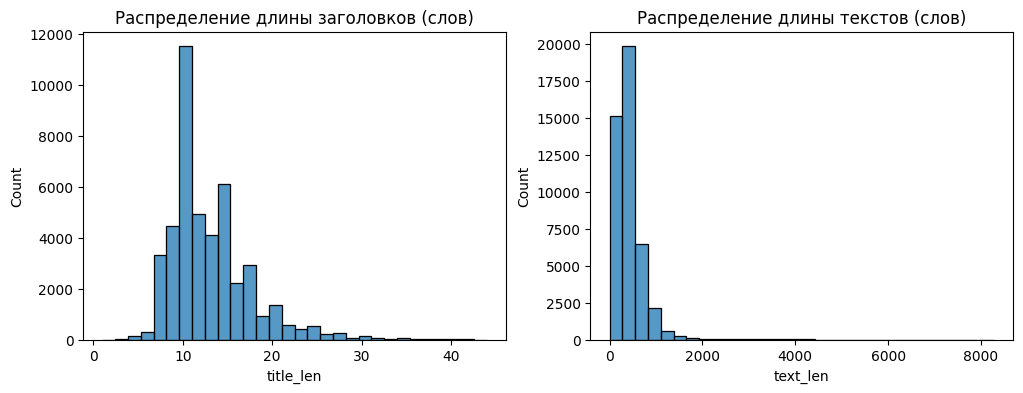

In [375]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['title_len'], bins=30, ax=axes[0])
axes[0].set_title('Распределение длины заголовков (слов)')
sns.histplot(df['text_len'], bins=30, ax=axes[1])
axes[1].set_title('Распределение длины текстов (слов)')
plt.show()

In [376]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(max_features=30, stop_words=stop_words)
X = vectorizer.fit_transform(df['title'].fillna(''))

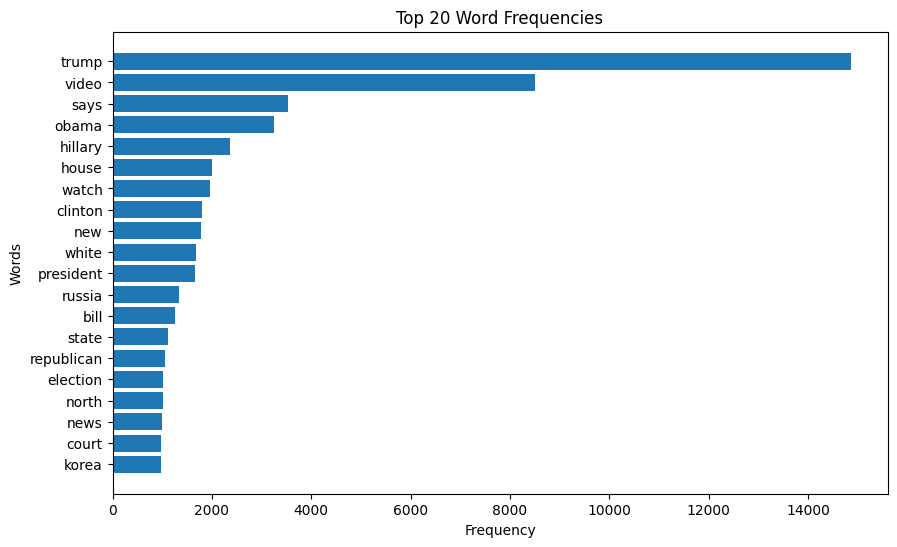

In [377]:
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

sorted_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]) # топ 20 самых популярных слов в заголовках

plt.figure(figsize=(10,6))
plt.barh(list(sorted_freq.keys())[::-1], list(sorted_freq.values())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies")
plt.show()

топ самых популярных слов в заголовках

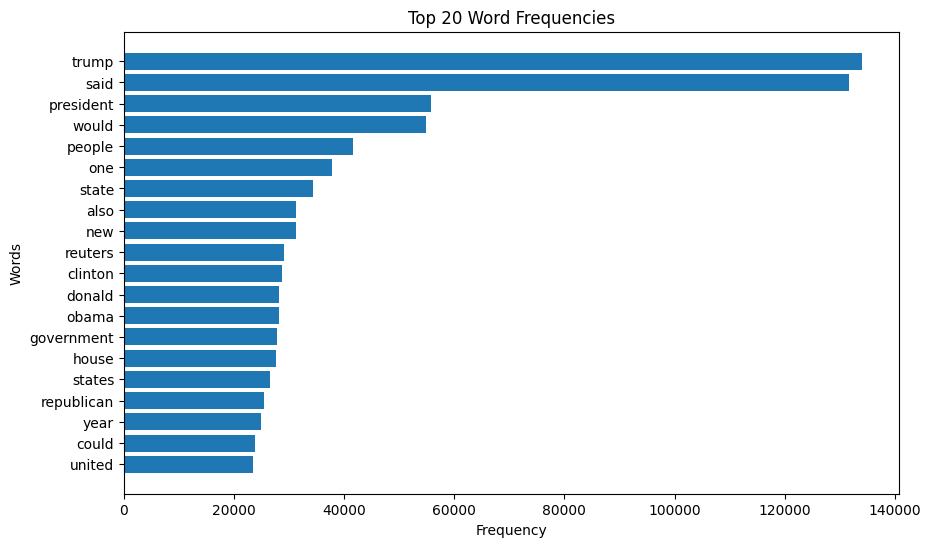

In [378]:
vectorizer = CountVectorizer(max_features=30, stop_words=stop_words) # сделаем тоже самое
X = vectorizer.fit_transform(df['text'].fillna(''))

word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

sorted_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]) # топ 20 самых популярных слов в текстах

plt.figure(figsize=(10,6))
plt.barh(list(sorted_freq.keys())[::-1], list(sorted_freq.values())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies")
plt.show()

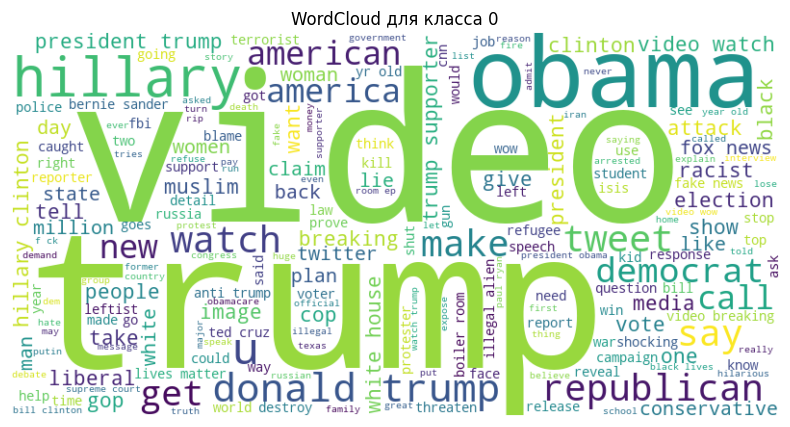

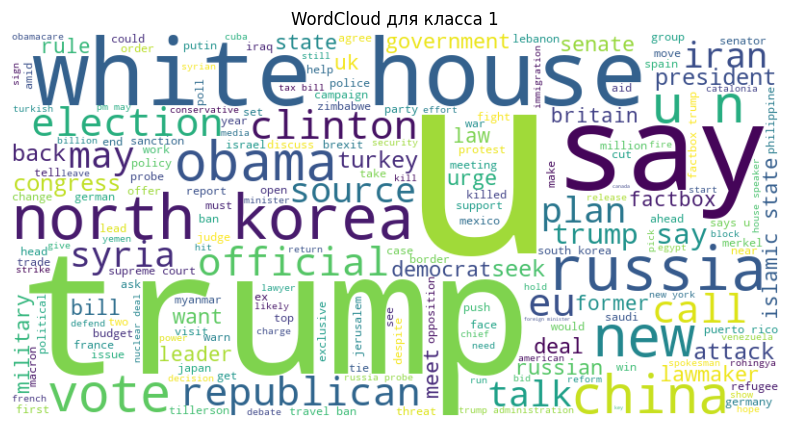

In [379]:
stop_words = set(stopwords.words('english'))


for cls in df['target'].unique():
    text_data = ' '.join(df[df['target'] == cls]['title'].fillna('').tolist())
    wc = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud для класса {cls}')
    plt.show()

Весьма вероятно что в какой то момент времени модель столкнется с data drift, из за смены новостной повестки. поэтому, дата публикации новости бесполезна, и скорее, даже вредна. модель просто сопоставит временной промежуток и темы публикаций

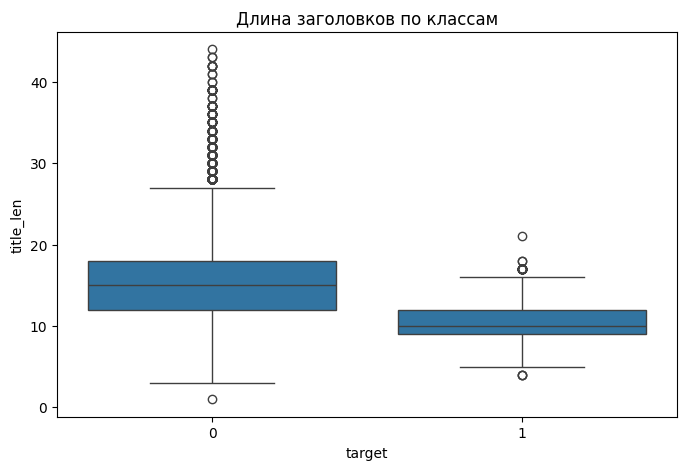

In [380]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='title_len', data=df)
plt.title('Длина заголовков по классам')
plt.show()

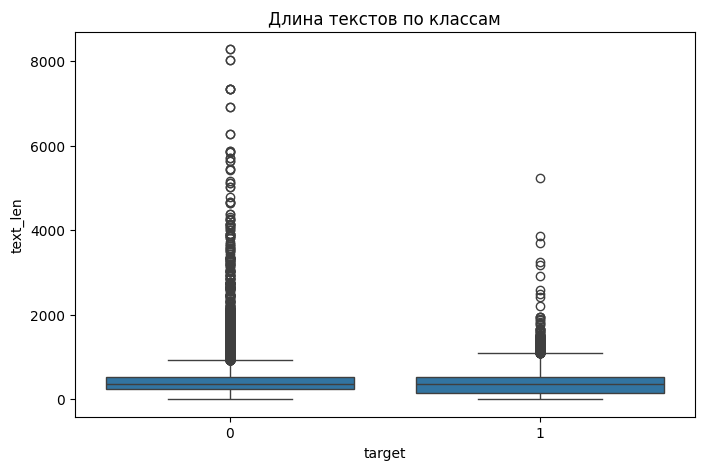

In [381]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='text_len', data=df)
plt.title('Длина текстов по классам')
plt.show()

можно заметить что в среднем правдивые новости короче

## CountVectorizer


In [382]:
df.drop(columns=['subject', 'date'], inplace=True)

In [383]:
df

,title,text,target,title_len,text_len
0,donald trump sends out embarrassing new year ...,donald trump just couldn t wish all americans ...,0,13,484
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,0,8,315
2,sheriff david clarke becomes an internet joke...,on friday it was revealed that former milwauke...,0,15,604
3,trump is so obsessed he even has obama s name...,on christmas day donald trump announced that h...,0,15,466
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,0,11,422
...,...,...,...,...,...
44893,fully committed nato backs new u s approach o...,brussels reuters nato allies on tuesday welcom...,1,10,463
44894,lexisnexis withdrew two products from chinese ...,london reuters lexisnexis a provider of legal ...,1,7,123
44895,minsk cultural hub becomes haven from authorities,minsk reuters in the shadow of disused soviet ...,1,7,321
44896,vatican upbeat on possibility of pope francis ...,moscow reuters vatican secretary of state card...,1,9,202


In [384]:
SEED = 42

In [385]:
X, y = divide_data(df, 'target')

Построим CountVectorizer модель только по телу новости и таргету

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)

y_train

682      0
40249    1
2325     0
12547    0
23819    1
        ..
16750    0
931      0
23776    1
6109     0
1309     0
Name: target, Length: 35751, dtype: int64

In [387]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stop_words, max_features=30)
X_train_text = vectorizer.fit_transform(X_train['text'].fillna(''))
X_test_text = vectorizer.fit_transform(X_test['text'].fillna(''))

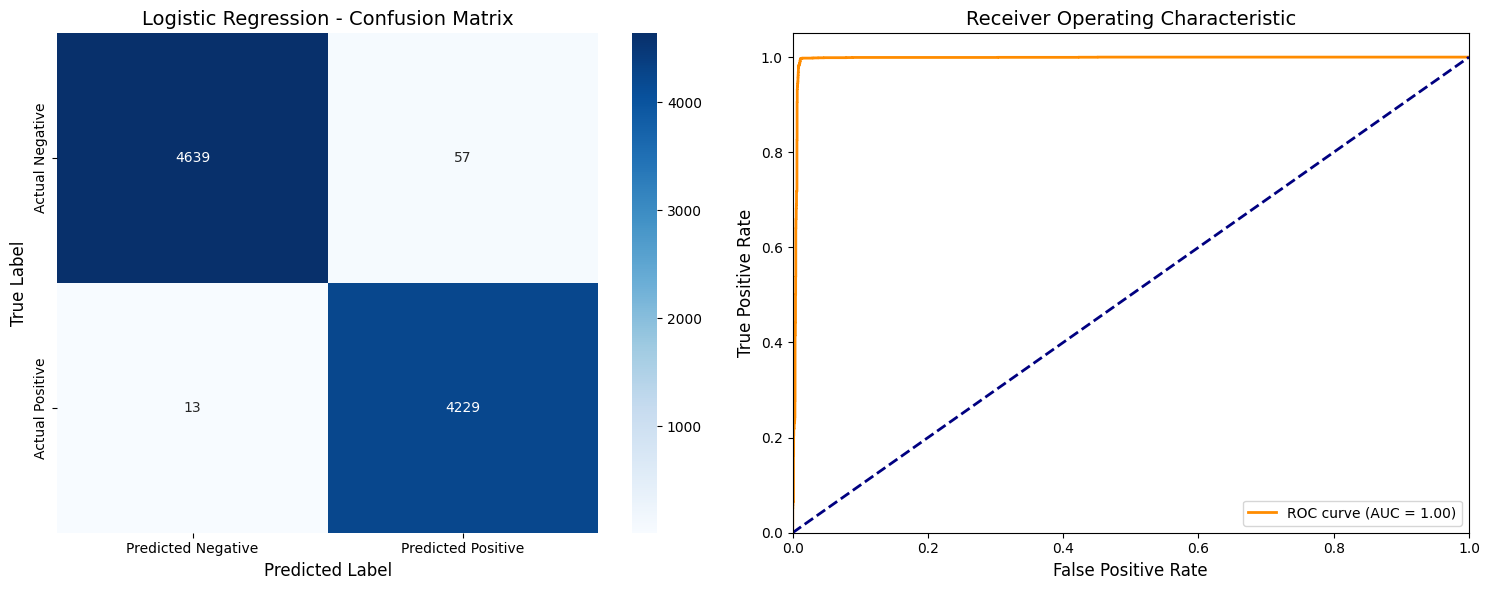


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9954
Average Precision 0.9895
         F1 Score 0.9922
        Precision 0.9920
           Recall 0.9924
         Accuracy 0.9922


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.986701 0.996935
Negative   0.997206 0.987862



In [388]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_text, y_train)

y_pred = log_reg.predict(X_test_text)
y_probs = log_reg.predict_proba(X_test_text)[:, 1]  

text_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

модель по тексту новости выше

In [389]:
X_train_title = vectorizer.fit_transform(X_train['title'].fillna(''))
X_test_title = vectorizer.fit_transform(X_test['title'].fillna(''))

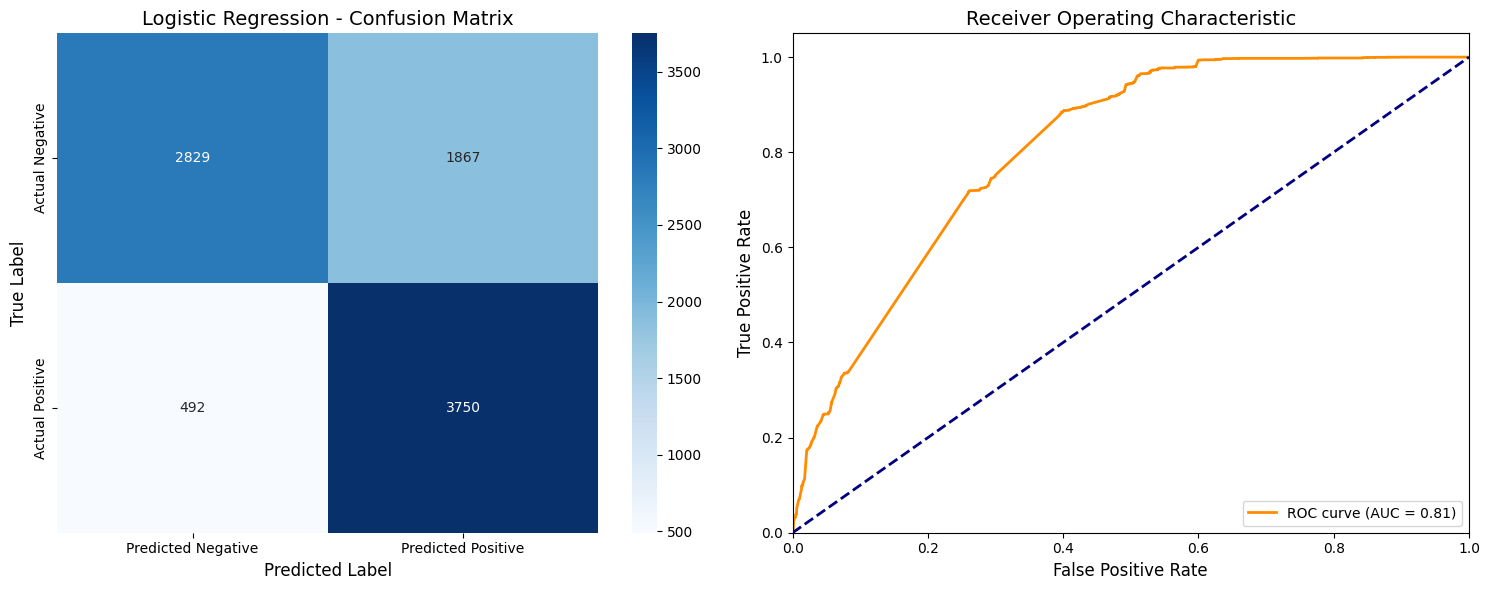


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.8095
Average Precision 0.7456
         F1 Score 0.7332
        Precision 0.7597
           Recall 0.7432
         Accuracy 0.7361


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.667616 0.884017
Negative   0.851852 0.602428



In [390]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_title, y_train)

y_pred = log_reg.predict(X_test_title)
y_probs = log_reg.predict_proba(X_test_title)[:, 1]  

title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Модель построенная только от текста намного лучше той, что строится только от заголовка. далее буду строить модели только по заголовкам, т.к. модель по тексту уже дает почти идеальный результат

## TfidfVectorizer

In [391]:
X_train.drop(columns=['title_len', 'text_len', 'text'], inplace=True)

X_test.drop(columns=['title_len', 'text_len', 'text'], inplace=True)

X_train = X_train["title"]
X_test = X_test["title"]


X_train

682       trump got another totally real letter from a ...
40249    cambodian pm says main opposition party will b...
2325      former secretary of state drops massive shock...
12547    absolutely stunning video shows how one hacker...
23819    in slap at romney trump says he wants hatch to...
                               ...                        
16750    the truth about apple vs the us government and...
931       trump brags about gas prices and gets humilia...
23776    corporate amt likely will not be in final u s ...
6109      bill kristol independent candidate will annou...
1309      hillary just showed the whole world that she ...
Name: title, Length: 35751, dtype: object

In [392]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [393]:
tfidf_pipe.fit(X_train, y_train)

y_pred = tfidf_pipe.predict(X_test)
y_probs = tfidf_pipe.predict_proba(X_test)[:, 1]  

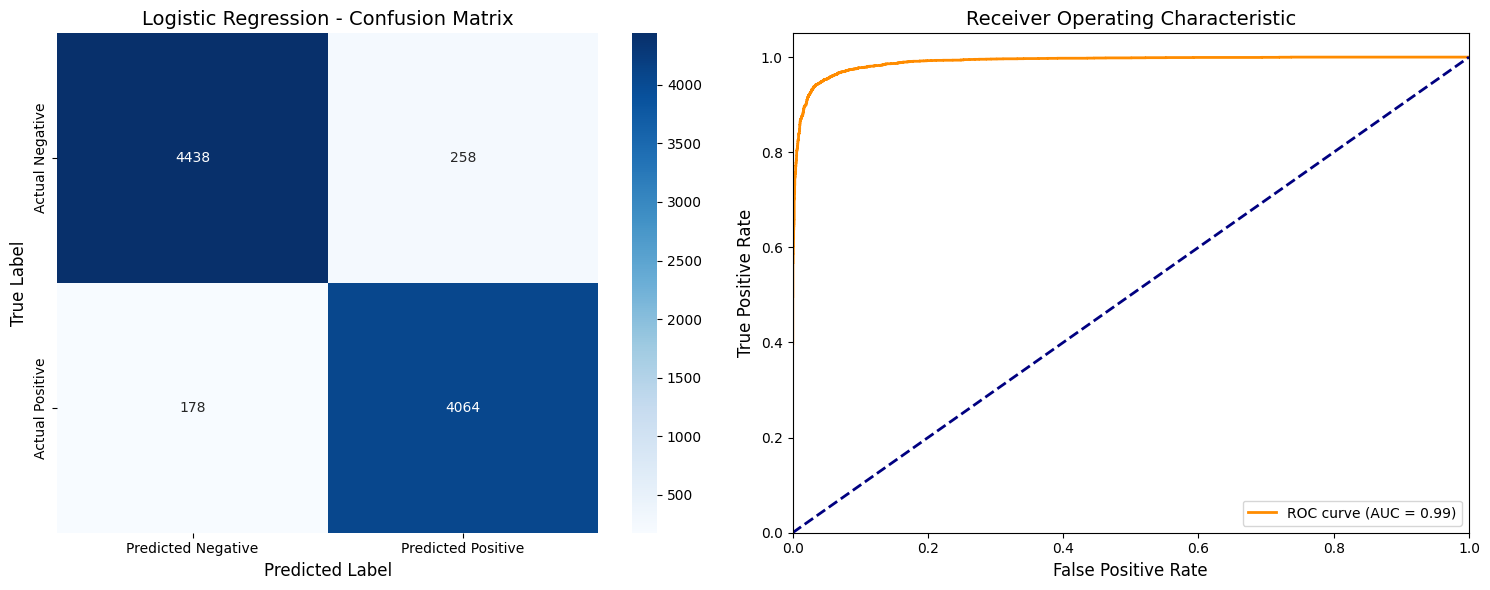


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9901
Average Precision 0.9898
         F1 Score 0.9511
        Precision 0.9509
           Recall 0.9515
         Accuracy 0.9512


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.940305 0.958039
Negative   0.961438 0.945060



In [394]:
tfidf_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

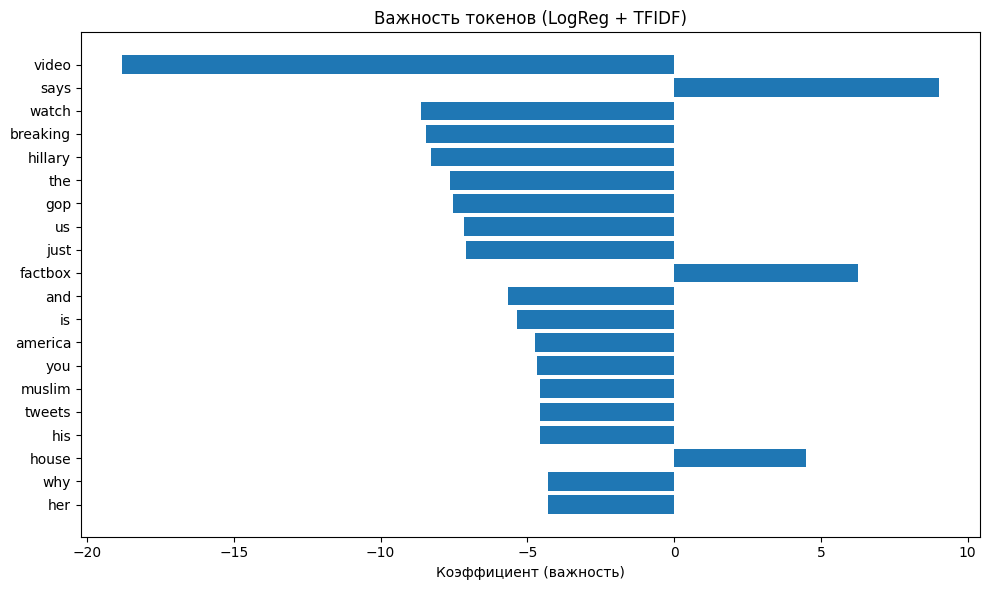

In [ ]:
feature_names = tfidf_pipe.named_steps['tfidf'].get_feature_names_out()
coefs = tfidf_pipe.named_steps['logreg'].coef_[0]

token_importance = pd.DataFrame({
    'token': feature_names,
    'coef': coefs
})

top_tokens = token_importance.reindex(token_importance['coef'].abs().sort_values(ascending=False).index)[:20] # учитываем все токены, даже отрицательные

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

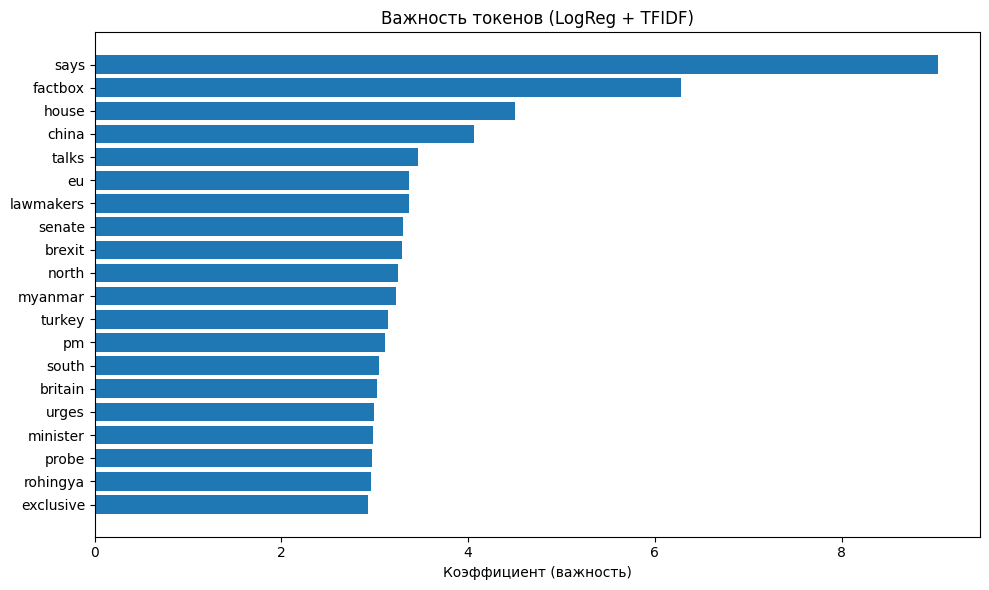

In [ ]:
top_tokens = token_importance.reindex(token_importance['coef'].sort_values(ascending=False).index)[:20] # только положительные

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Намного лучше чем CountVectorizer

## HashingVectorizer

In [396]:
hashing_pipe = Pipeline([
    ('hashing', HashingVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [397]:
hashing_pipe.fit(X_train, y_train)

y_pred = hashing_pipe.predict(X_test)
y_probs = hashing_pipe.predict_proba(X_test)[:, 1]  

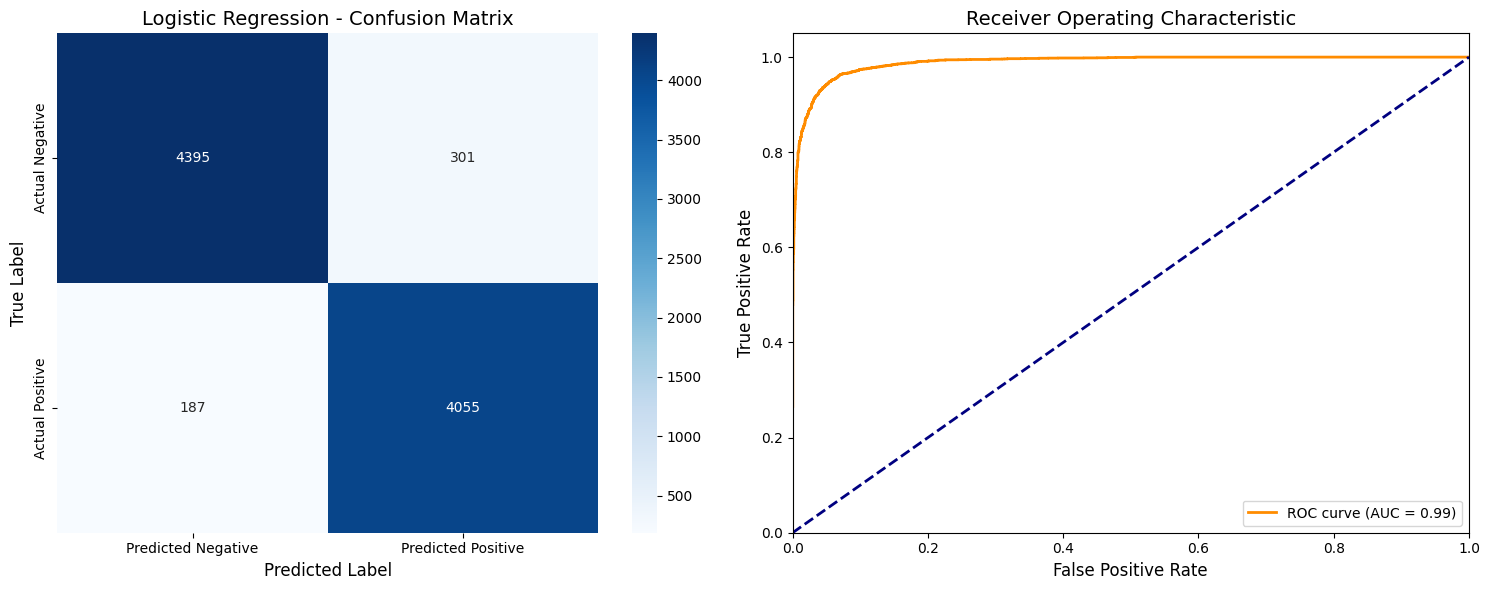


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9884
Average Precision 0.9875
         F1 Score 0.9453
        Precision 0.9450
           Recall 0.9459
         Accuracy 0.9454


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.930900 0.955917
Negative   0.959188 0.935903



In [400]:
hashing_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

примерно на том же уровне что и TFIDF

## Посмотрим как модели ведут себя без предобработки текста

Нет никакой предобработки: ни удаления знаков препинания, ни токенизации

In [401]:
df = pd.read_csv('dataset.csv', index_col=0)

In [402]:
X, y = divide_data(df, 'target')

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)

In [404]:
X_train = X_train['title']
X_test = X_test['title']

X_train

37645    SocGen says no wrongdoing in handling of Natio...
30390    North Carolina governor concedes election to D...
18191    TRUMP FEVER! W. VA Dem Senator Says He Won’t V...
25384    New York vows to sue Trump over immigrant chil...
32622    Orlando killer expressed support for multiple ...
                               ...                        
9967     N KOREA JUST REVEALED Plans To Unleash An Unim...
26591    Trump to meet with top executives on wireless ...
8895      WATCH: Obama Goes BEAST MODE On CNN Anchor Fo...
18855    YIKES! Hillary Still Needs Help Walking On Sta...
41192    China's top paper warns party officials agains...
Name: title, Length: 35918, dtype: object

In [405]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

tfidf_pipe.fit(X_train, y_train)

y_pred = tfidf_pipe.predict(X_test)
y_probs = tfidf_pipe.predict_proba(X_test)[:, 1]  

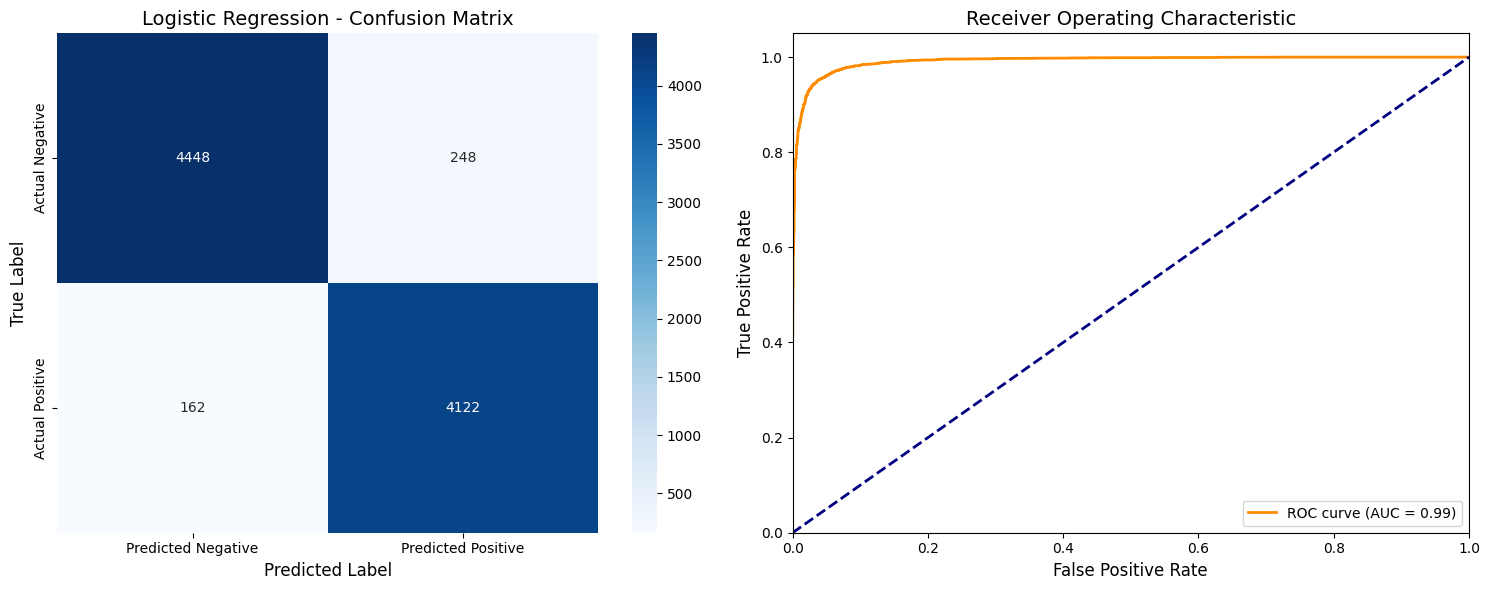


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9914
Average Precision 0.9911
         F1 Score 0.9543
        Precision 0.9541
           Recall 0.9547
         Accuracy 0.9543


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.943249 0.962185
Negative   0.964859 0.947189



In [406]:
tfidf_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Есть улучшение рок аука на 0.001%. по итогу, лучше удалить, прироста фактически нет

Построим диаграмму важности токенов

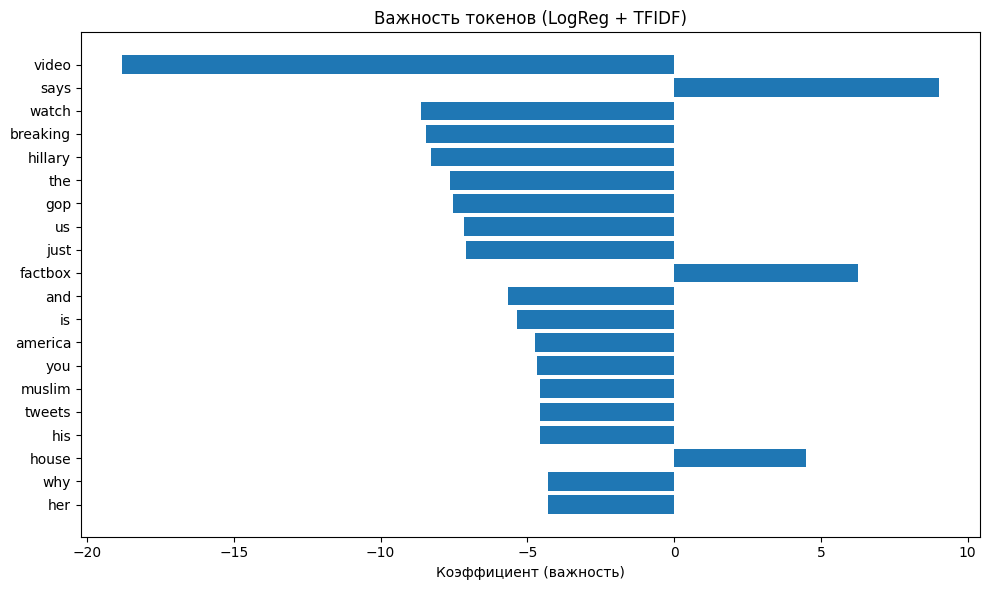

In [407]:
feature_names = tfidf_pipe.named_steps['tfidf'].get_feature_names_out()
coefs = tfidf_pipe.named_steps['logreg'].coef_[0]

token_importance = pd.DataFrame({
    'token': feature_names,
    'coef': coefs
})

top_tokens = token_importance.reindex(token_importance['coef'].abs().sort_values(ascending=False).index)[:20]

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()